In [1]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# set defaults
plt.rcParams['figure.dpi'] = 80


In [2]:
# read data
df = pd.read_csv('../data/kddcup.data_0_1_percent.csv', index_col=0)
df.head()  # small view


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
22650,1,tcp,smtp,SF,1022,389,0,0,0,0,...,175,0.64,0.02,0.01,0.02,0.0,0.0,0.0,0.0,normal.
5765,0,tcp,http,SF,376,285,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
241826,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
292391,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
392127,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.


In [3]:
# filter labels
labels = df['41']  # get labels
label_counts = labels.value_counts()  # n-obs / label
mask = label_counts > df.shape[0] * 0.05  # label must encompass > 5% of the data
valid_labels = label_counts.index[mask]  # get passing labels
print(f'Passing labels = {valid_labels.tolist()}')
df = df[df['41'].isin(valid_labels)]
labels = df['41']  # redefine labels


Passing labels = ['smurf.', 'neptune.', 'normal.']


In [123]:
# extract data
X,y = df.copy().iloc[:,:-1].select_dtypes(['number']),df.copy()['41']
# standardize
X -= X.mean()
X /= X.std()
# remove constant columns
X = X.dropna(axis=1)
# reset index for categorical mapping
X = X.reset_index().iloc[:,1:]

In [124]:
# set up one hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
# add on protocol
cats = pd.DataFrame(ohe.fit_transform(df[['1']]).toarray())
X = X.join(cats, rsuffix='cat1')
# add on short categorical
cats = pd.DataFrame(ohe.fit_transform(df[['3']]).toarray())
X = X.join(cats, rsuffix='cat2')

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca = PCA(n_components=10, svd_solver='full', random_state=0)

In [130]:
pca.fit(X.T)

PCA(n_components=10, random_state=0, svd_solver='full')

<BarContainer object of 10 artists>

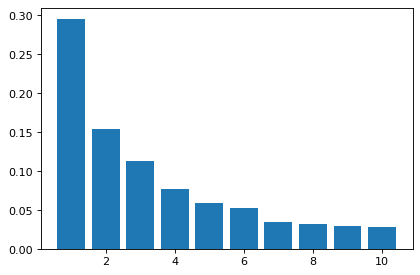

In [131]:
plt.bar(range(1,11), pca.explained_variance_ratio_)

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2'), Text(0.5, 1.0, 'PCA')]

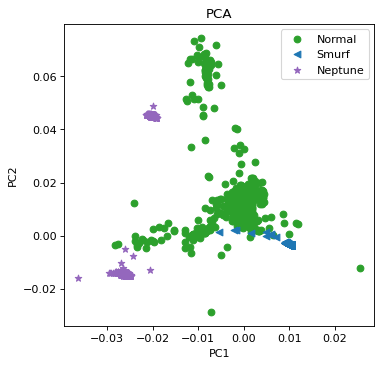

In [178]:
color_dict = {'normal.':'tab:green','smurf.':'tab:blue','neptune.':'tab:purple'}
marker_dict = {'normal.':'o','smurf.': '<','neptune.':'*'}
fig,ax = plt.subplots(figsize=[5,5])
for cat in color_dict:
    mask = (df['41']==cat).values
    ax.scatter(projection.loc[mask,'PC1'], projection.loc[mask,'PC2'], label=cat[:-1].title(),
               color=color_dict[cat], marker=marker_dict[cat])
ax.legend()
ax.tick_params(labelsize=10)
ax.set(xlabel='PC1', ylabel='PC2', title='PCA')

In [154]:
# get density
from scipy.stats import gaussian_kde
xy = np.vstack([projection['PC1'],projection['PC2']])
z = gaussian_kde(xy)(xy)


[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2'), Text(0.5, 1.0, 'Intrusion (Smurf)')]

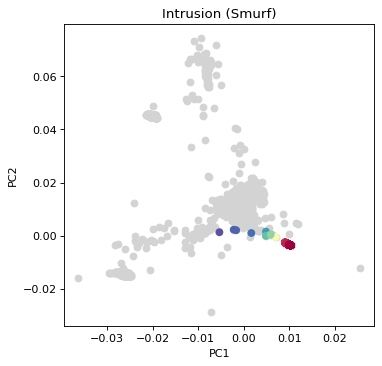

In [175]:
# plot smurf density
fig,ax = plt.subplots(figsize=[5,5])
mask = (df['41']=='smurf.').values
ax.scatter(projection['PC1'], projection['PC2'], label=cat, color='lightgray')
ax.scatter(projection.loc[mask,'PC1'], projection.loc[mask,'PC2'], label=cat, c=z[mask], cmap='Spectral_r')
ax.tick_params(labelsize=10)
ax.set(xlabel='PC1', ylabel='PC2', title='Intrusion (Smurf)')


[Text(0.5, 0, 'PC1'),
 Text(0, 0.5, 'PC2'),
 Text(0.5, 1.0, 'Intrusion (Neptune)')]

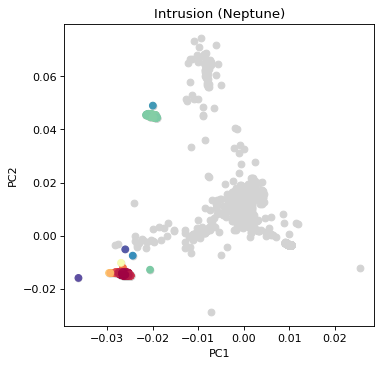

In [176]:
# plot neptune density
fig,ax = plt.subplots(figsize=[5,5])
mask = (df['41']=='neptune.').values
ax.scatter(projection['PC1'], projection['PC2'], label=cat, color='lightgray')
ax.scatter(projection.loc[mask,'PC1'], projection.loc[mask,'PC2'], label=cat, c=z[mask], cmap='Spectral_r')
ax.tick_params(labelsize=10)
ax.set(xlabel='PC1', ylabel='PC2', title='Intrusion (Neptune)')


[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2'), Text(0.5, 1.0, 'Normal')]

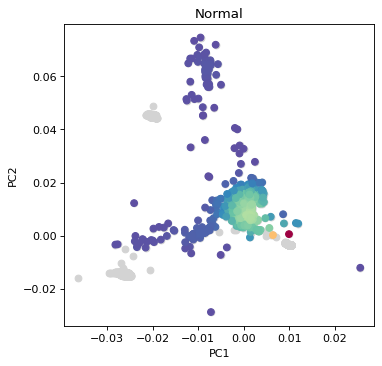

In [177]:
# plot normal density
fig,ax = plt.subplots(figsize=[5,5])
mask = (df['41']=='normal.').values
ax.scatter(projection['PC1'], projection['PC2'], label=cat, color='lightgray')
cax=ax.scatter(projection.loc[mask,'PC1'], projection.loc[mask,'PC2'], label=cat, c=z[mask], cmap='Spectral_r')
ax.tick_params(labelsize=10)
ax.set(xlabel='PC1', ylabel='PC2', title='Normal')
